Epoch 10/200, Loss: 0.4493
Epoch 20/200, Loss: -0.2275
Epoch 30/200, Loss: -0.3593
Epoch 40/200, Loss: -0.4446
Epoch 50/200, Loss: -0.4774
Epoch 60/200, Loss: -0.4913
Epoch 70/200, Loss: -0.4998
Epoch 80/200, Loss: -0.5029
Epoch 90/200, Loss: -0.5097
Epoch 100/200, Loss: -0.5203
Epoch 110/200, Loss: -0.5299
Epoch 120/200, Loss: -0.5680
Epoch 130/200, Loss: -0.6034
Epoch 140/200, Loss: -0.6312
Epoch 150/200, Loss: -0.6544
Epoch 160/200, Loss: -0.6715
Epoch 170/200, Loss: -0.6851
Epoch 180/200, Loss: -0.6954
Epoch 190/200, Loss: -0.7035
Epoch 200/200, Loss: -0.7112


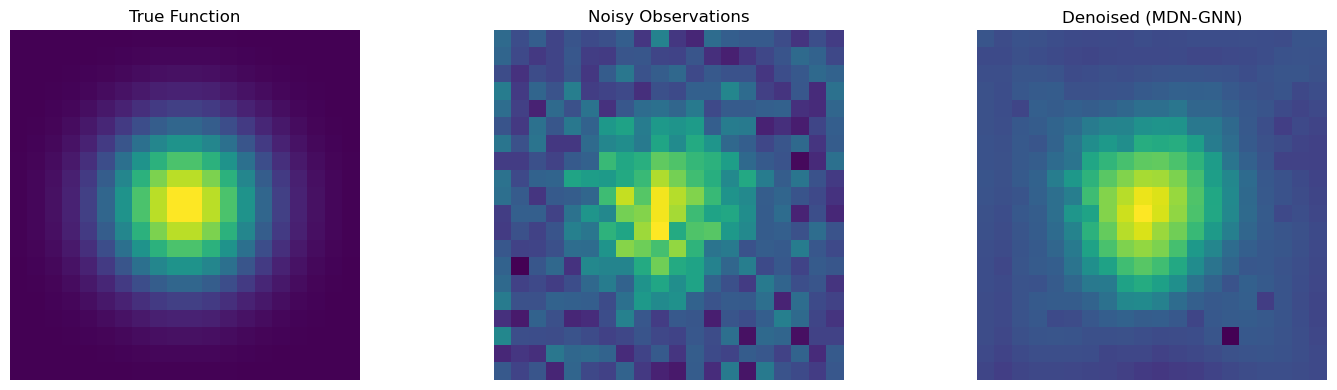

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.utils import grid as pg_grid
import math

# ---------------------
# Posterior computation
# ---------------------
class PosteriorResult:
    def __init__(self, post_mean, post_mean2, post_sd):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd

def posterior_mean_norm(betahat, sebetahat, log_pi, location, scale):
    pi = np.exp(log_pi - np.max(log_pi))
    pi /= np.sum(pi)
    total_var = scale**2 + sebetahat**2
    w = pi * np.exp(-(betahat - location)**2 / (2 * total_var)) / np.sqrt(total_var)
    w /= np.sum(w)
    post_mean = np.sum(w * (location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))
    post_mean2 = np.sum(w * ((location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))**2 +
                        (scale**2 * sebetahat**2) / (scale**2 + sebetahat**2))
    post_sd = math.sqrt(post_mean2 - post_mean**2)
    return PosteriorResult(post_mean, post_mean2, post_sd)

# ---------------------
# Graph MDN model
# ---------------------
class GraphMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians, n_layers=2):
        super(GraphMDN, self).__init__()
        self.convs = nn.ModuleList([
            GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(n_layers)
        ])
        self.pi = nn.Linear(hidden_dim, n_gaussians)
        self.mu = nn.Linear(hidden_dim, n_gaussians)
        self.log_sigma = nn.Linear(hidden_dim, n_gaussians)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = torch.relu(conv(x, edge_index))
        pi = torch.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        return pi, mu, log_sigma

# ---------------------
# Loss function
# ---------------------
def mdn_loss_with_varying_noise(pi, mu, log_sigma, betahat, sebetahat):
    sigma = torch.exp(log_sigma)
    total_sigma = torch.sqrt(sigma**2 + sebetahat.unsqueeze(1)**2)
    dist = torch.distributions.Normal(mu, total_sigma)
    log_probs = dist.log_prob(betahat.unsqueeze(1)) + torch.log(pi + 1e-8)
    nll = -torch.logsumexp(log_probs, dim=1)
    return nll.mean()

# ---------------------
# Posterior container
# ---------------------
class EmdnPosteriorMeanNorm:
    def __init__(self, post_mean, post_mean2, post_sd, loss=0, model_param=None):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.loss = loss
        self.model_param = model_param

# ---------------------
# Main training function
# ---------------------
def emdn_posterior_means_graph(node_features, edge_index, betahat, sebetahat, n_epochs=50, n_gaussians=5,
                                hidden_dim=64, lr=0.001, model_param=None, n_layers=2):
    x = torch.tensor(node_features, dtype=torch.float32)
    ei = edge_index
    betahat = torch.tensor(betahat, dtype=torch.float32)
    sebetahat = torch.tensor(sebetahat, dtype=torch.float32)

    input_dim = x.shape[1]
    model = GraphMDN(input_dim, hidden_dim, n_gaussians, n_layers)
    if model_param is not None:
        model.load_state_dict(model_param)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        pi, mu, log_sigma = model(x, ei)
        loss = mdn_loss_with_varying_noise(pi, mu, log_sigma, betahat, sebetahat)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        pi, mu, log_sigma = model(x, ei)
        all_pi = pi.cpu().numpy()
        all_mu = mu.cpu().numpy()
        all_log_sigma = log_sigma.cpu().numpy()

    post_mean = np.zeros(len(betahat))
    post_mean2 = np.zeros(len(betahat))
    post_sd = np.zeros(len(betahat))

    for i in range(len(betahat)):
        result = posterior_mean_norm(
            betahat=np.array([betahat[i].item()]),
            sebetahat=np.array([sebetahat[i].item()]),
            log_pi=np.log(all_pi[i, :] + 1e-8),
            location=all_mu[i, :],
            scale=np.sqrt(np.exp(all_log_sigma[i, :])**2)
        )
        post_mean[i] = result.post_mean
        post_mean2[i] = result.post_mean2
        post_sd[i] = result.post_sd

    return EmdnPosteriorMeanNorm(post_mean, post_mean2, post_sd, loss=loss.item(), model_param=model.state_dict())

# ---------------------
# Build grid + simulate data
# ---------------------
# 1. Create 2D grid graph
grid_size = 20
num_nodes = grid_size * grid_size
rows, cols = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing="ij")
node_indices = rows * grid_size + cols
edge_index = []

for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        if i + 1 < grid_size:
            edge_index.append([idx, (i + 1) * grid_size + j])
        if j + 1 < grid_size:
            edge_index.append([idx, i * grid_size + (j + 1)])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape [2, num_edges]

# 2. 2D coordinates as node features
x_coords, y_coords = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
node_features = np.stack([x_coords.ravel(), y_coords.ravel()], axis=1)

# 3. True function and noise
def true_function(x, y):
    return np.exp(-5 * (x**2 + y**2))

true_values = true_function(node_features[:, 0], node_features[:, 1])
np.random.seed(42)
sebetahat = 0.1 + 0.05 * np.random.rand(num_nodes)
noise = np.random.randn(num_nodes) * sebetahat
betahat = true_values + noise

# 4. Fit model
result = emdn_posterior_means_graph(
    node_features=node_features,
    edge_index=edge_index,
    betahat=betahat,
    sebetahat=sebetahat,
    n_epochs=200,
    n_gaussians=5,
    hidden_dim=64,
    lr=0.005
)

# 5. Plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(true_values.reshape(grid_size, grid_size), cmap="viridis")
axs[0].set_title("True Function")

axs[1].imshow(betahat.reshape(grid_size, grid_size), cmap="viridis")
axs[1].set_title("Noisy Observations")

axs[2].imshow(result.post_mean.reshape(grid_size, grid_size), cmap="viridis")
axs[2].set_title("Denoised (MDN-GNN)")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


Epoch 10/100, Loss: 0.3978
Epoch 20/100, Loss: 0.0063
Epoch 30/100, Loss: -0.0512
Epoch 40/100, Loss: -0.0932
Epoch 50/100, Loss: -0.1354
Epoch 60/100, Loss: -0.1740
Epoch 70/100, Loss: -0.1982
Epoch 80/100, Loss: -0.2340
Epoch 90/100, Loss: -0.2686
Epoch 100/100, Loss: -0.2582


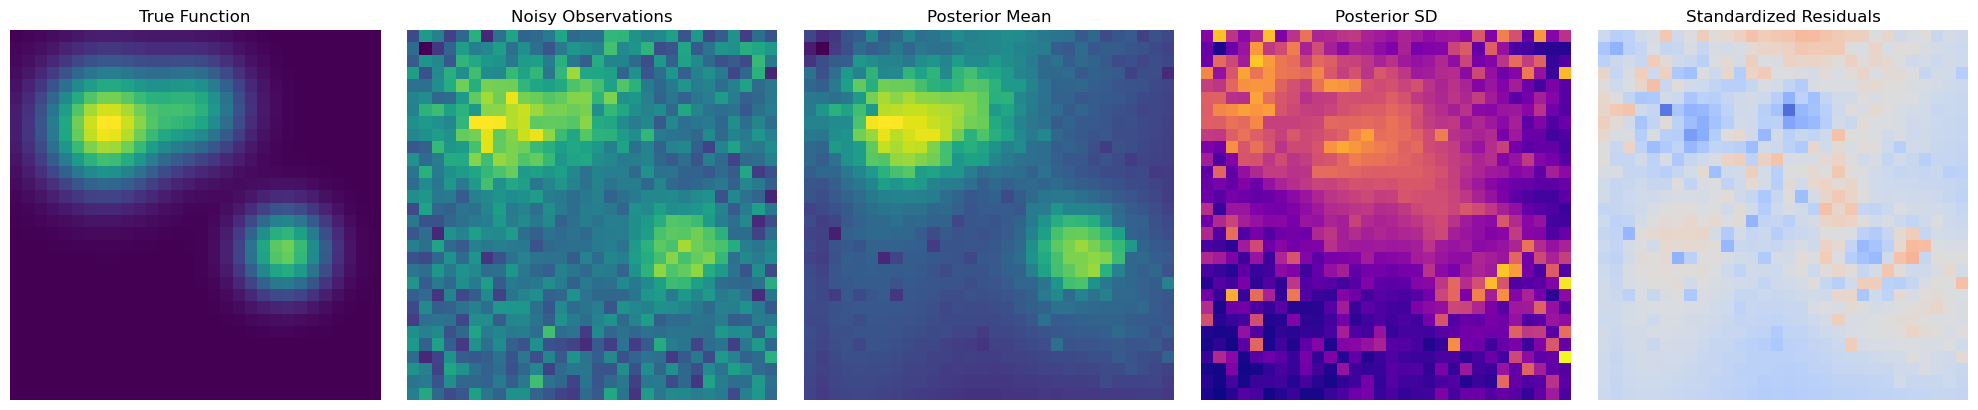

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import math

# ---------------------
# Posterior computation
# ---------------------
class PosteriorResult:
    def __init__(self, post_mean, post_mean2, post_sd):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd

def posterior_mean_norm(betahat, sebetahat, log_pi, location, scale):
    pi = np.exp(log_pi - np.max(log_pi))
    pi /= np.sum(pi)
    total_var = scale**2 + sebetahat**2
    w = pi * np.exp(-(betahat - location)**2 / (2 * total_var)) / np.sqrt(total_var)
    w /= np.sum(w)
    post_mean = np.sum(w * (location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))
    post_mean2 = np.sum(w * ((location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))**2 +
                        (scale**2 * sebetahat**2) / (scale**2 + sebetahat**2))
    post_sd = math.sqrt(post_mean2 - post_mean**2)
    return PosteriorResult(post_mean, post_mean2, post_sd)

# ---------------------
# GraphMDN Model
# ---------------------
class GraphMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians, n_layers=2):
        super(GraphMDN, self).__init__()
        self.convs = nn.ModuleList([
            GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(n_layers)
        ])
        self.pi = nn.Linear(hidden_dim, n_gaussians)
        self.mu = nn.Linear(hidden_dim, n_gaussians)
        self.log_sigma = nn.Linear(hidden_dim, n_gaussians)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = torch.relu(conv(x, edge_index))
        pi = torch.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        return pi, mu, log_sigma

# ---------------------
# MDN Loss
# ---------------------
def mdn_loss_with_varying_noise(pi, mu, log_sigma, betahat, sebetahat):
    sigma = torch.exp(log_sigma)
    total_sigma = torch.sqrt(sigma**2 + sebetahat.unsqueeze(1)**2)
    dist = torch.distributions.Normal(mu, total_sigma)
    log_probs = dist.log_prob(betahat.unsqueeze(1)) + torch.log(pi + 1e-8)
    nll = -torch.logsumexp(log_probs, dim=1)
    return nll.mean()

# ---------------------
# Posterior output container
# ---------------------
class EmdnPosteriorMeanNorm:
    def __init__(self, post_mean, post_mean2, post_sd, loss=0, model_param=None):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.loss = loss
        self.model_param = model_param

# ---------------------
# Training function
# ---------------------
def emdn_posterior_means_graph(node_features, edge_index, betahat, sebetahat, n_epochs=100, n_gaussians=5,
                                hidden_dim=64, lr=0.005, model_param=None, n_layers=2, batch_size=None):
    x = torch.tensor(node_features, dtype=torch.float32)
    ei = edge_index
    betahat = torch.tensor(betahat, dtype=torch.float32)
    sebetahat = torch.tensor(sebetahat, dtype=torch.float32)

    input_dim = x.shape[1]
    model = GraphMDN(input_dim, hidden_dim, n_gaussians, n_layers)
    if model_param is not None:
        model.load_state_dict(model_param)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_nodes = x.size(0)

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass on full graph
        pi, mu, log_sigma = model(x, ei)

        # Select a random mini-batch
        if batch_size is not None and batch_size < num_nodes:
            idx = torch.randperm(num_nodes)[:batch_size]
        else:
            idx = torch.arange(num_nodes)

        # Compute loss on batch
        loss = mdn_loss_with_varying_noise(pi[idx], mu[idx], log_sigma[idx], betahat[idx], sebetahat[idx])
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

    # Final full pass for posterior estimation
    model.eval()
    with torch.no_grad():
        pi, mu, log_sigma = model(x, ei)
        all_pi = pi.cpu().numpy()
        all_mu = mu.cpu().numpy()
        all_log_sigma = log_sigma.cpu().numpy()

    post_mean = np.zeros(len(betahat))
    post_mean2 = np.zeros(len(betahat))
    post_sd = np.zeros(len(betahat))

    for i in range(len(betahat)):
        result = posterior_mean_norm(
            betahat=np.array([betahat[i].item()]),
            sebetahat=np.array([sebetahat[i].item()]),
            log_pi=np.log(all_pi[i, :] + 1e-8),
            location=all_mu[i, :],
            scale=np.sqrt(np.exp(all_log_sigma[i, :])**2)
        )
        post_mean[i] = result.post_mean
        post_mean2[i] = result.post_mean2
        post_sd[i] = result.post_sd

    return EmdnPosteriorMeanNorm(post_mean, post_mean2, post_sd, loss=loss.item(), model_param=model.state_dict())

# ---------------------
# Generate more complex data
# ---------------------
grid_size = 30
num_nodes = grid_size * grid_size

# Build edge index for grid graph
rows, cols = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing="ij")
edge_index_list = []
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        if i + 1 < grid_size:
            edge_index_list.append([idx, (i + 1) * grid_size + j])
        if j + 1 < grid_size:
            edge_index_list.append([idx, i * grid_size + (j + 1)])
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# 3 features: x, y, radius from center
x_coords, y_coords = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
r_flat = np.sqrt(x_flat**2 + y_flat**2)
node_features = np.stack([x_flat, y_flat, r_flat], axis=1)

# True signal = multiple bumps
def true_function(x, y):
    return (
        1.0 * np.exp(-10 * ((x + 0.5)**2 + (y + 0.5)**2)) +
        0.8 * np.exp(-20 * ((x - 0.5)**2 + (y - 0.2)**2)) +
        0.6 * np.exp(-15 * ((x)**2 + (y + 0.6)**2))
    )
true_values = true_function(x_flat, y_flat)

# Heteroskedastic noise
np.random.seed(123)
sebetahat = 0.05 + 0.15 * r_flat
noise = np.random.randn(num_nodes) * sebetahat
betahat = true_values + noise

# ---------------------
# Run GraphMDN
# ---------------------
result = emdn_posterior_means_graph(
    node_features=node_features,
    edge_index=edge_index,
    betahat=betahat,
    sebetahat=sebetahat,
    n_epochs=100,
    n_gaussians=5,
    hidden_dim=64,
    lr=0.005
)

# ---------------------
# Visualize results
# ---------------------
true_img = true_values.reshape(grid_size, grid_size)
obs_img = betahat.reshape(grid_size, grid_size)
mean_img = result.post_mean.reshape(grid_size, grid_size)
sd_img = result.post_sd.reshape(grid_size, grid_size)
resid_img = ((result.post_mean - true_values) / sebetahat).reshape(grid_size, grid_size)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(true_img, cmap="viridis")
axs[0].set_title("True Function")

axs[1].imshow(obs_img, cmap="viridis")
axs[1].set_title("Noisy Observations")

axs[2].imshow(mean_img, cmap="viridis")
axs[2].set_title("Posterior Mean")

axs[3].imshow(sd_img, cmap="plasma")
axs[3].set_title("Posterior SD")

axs[4].imshow(resid_img, cmap="coolwarm", vmin=-3, vmax=3)
axs[4].set_title("Standardized Residuals")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [17]:
import sys
sys.path.append(r"C:\Document\Serieux\Travail\python_work\nash\py") 
from fused_lasso_python import *
print("Running Fused Lasso...")
fused = FusedLASSO(optimizer='momentum', alpha=0.5, l=0.3, n_iter=500, momentum=0.9, verbose=True)
beta_fused_img = fused.fit_transform(betahat.reshape(grid_size, grid_size))
beta_fused = beta_fused_img.ravel()

# Compute MSEs
def compute_mse(x, y):
    return np.mean((x - y)**2)

mse_mdn = compute_mse(result.post_mean, true_values)
mse_fused = compute_mse(beta_fused, true_values)

print(f"\nGraphMDN MSE:    {mse_mdn:.5f}")
print(f"Fused Lasso MSE: {mse_fused:.5f}")


Running Fused Lasso...
100: MSE = 604.4551912163013
200: MSE = 594.5647460217772
300: MSE = 644.6731704468853
400: MSE = 639.7701641103513

GraphMDN MSE:    0.00689
Fused Lasso MSE: 0.68493


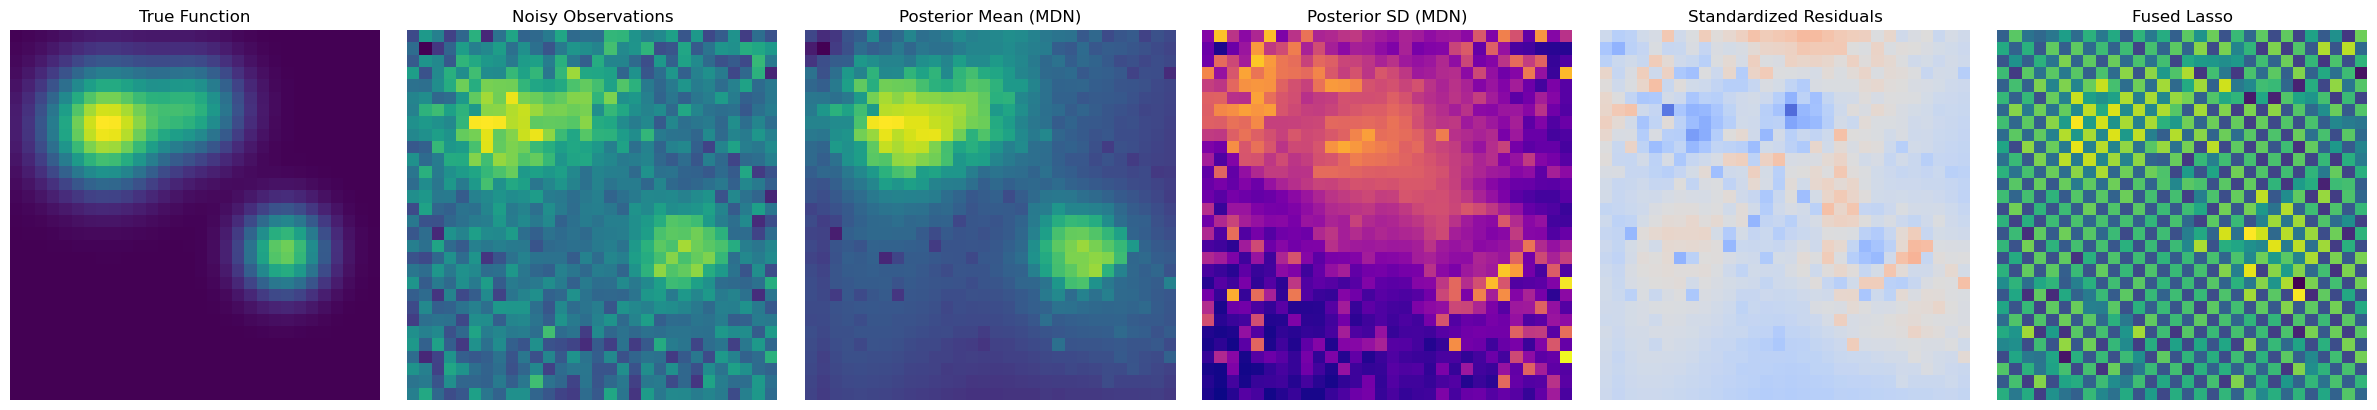

In [18]:
fig, axs = plt.subplots(1, 6, figsize=(24, 4))
axs[0].imshow(true_img, cmap="viridis")
axs[0].set_title("True Function")

axs[1].imshow(obs_img, cmap="viridis")
axs[1].set_title("Noisy Observations")

axs[2].imshow(mean_img, cmap="viridis")
axs[2].set_title("Posterior Mean (MDN)")

axs[3].imshow(sd_img, cmap="plasma")
axs[3].set_title("Posterior SD (MDN)")

axs[4].imshow(resid_img, cmap="coolwarm", vmin=-3, vmax=3)
axs[4].set_title("Standardized Residuals")

axs[5].imshow(beta_fused_img, cmap="viridis")
axs[5].set_title("Fused Lasso")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


irregular graph data

Epoch 0: Loss 0.9747
Epoch 10: Loss 0.2159
Epoch 20: Loss 0.0656
Epoch 30: Loss -0.0746
Epoch 40: Loss -0.2180
Epoch 50: Loss -0.3368
Epoch 60: Loss -0.4055
Epoch 70: Loss -0.4713
Epoch 80: Loss -0.5040
Epoch 90: Loss -0.5417
Running Fused Lasso...


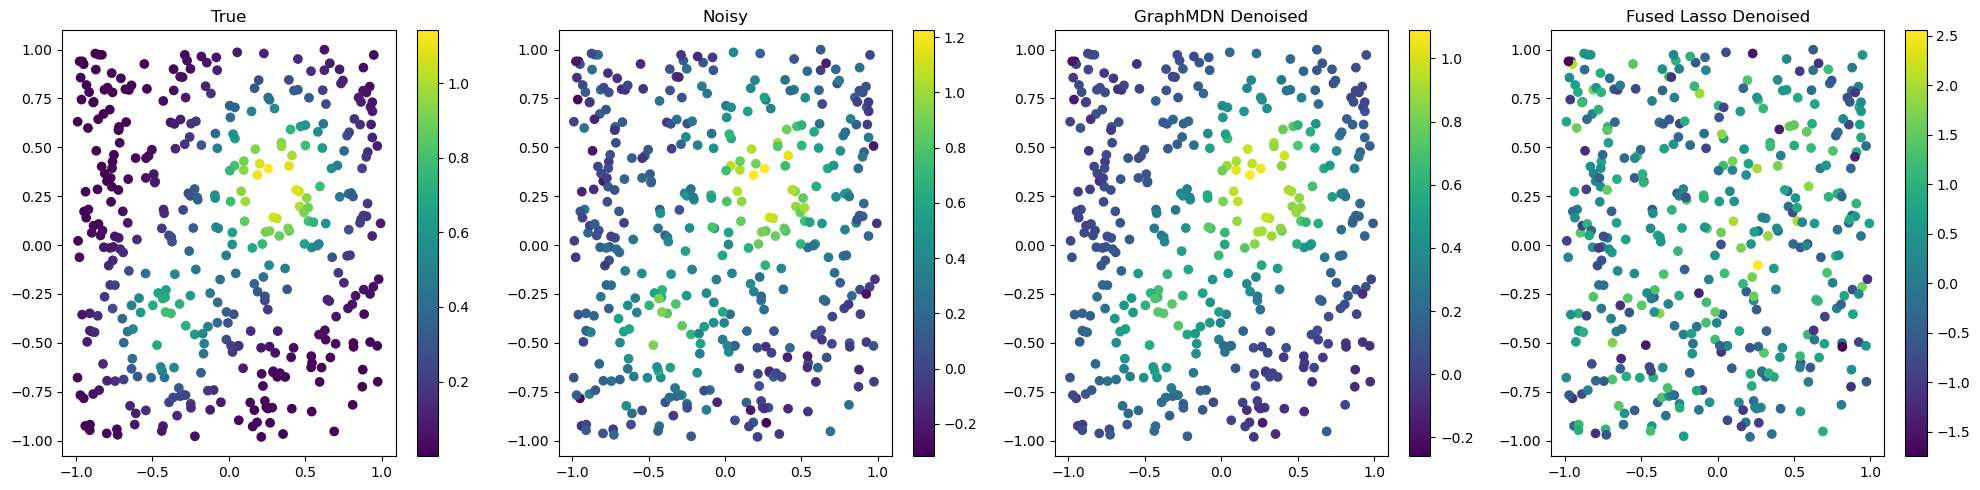

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from torch_geometric.nn import GCNConv
import math

# ----- Use your FusedLASSO class here -----
# Paste your FusedLASSO class definition above this line (unchanged)
# Make sure it's defined before running the rest

# Generate random 2D points
np.random.seed(42)
num_nodes = 400
points = np.random.rand(num_nodes, 2) * 2 - 1  # Uniform in [-1, 1]^2

# k-NN graph (symmetric)
k = 6
A = kneighbors_graph(points, k, mode='connectivity', include_self=False)
A = A.maximum(A.T)
edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long)  # shape [2, num_edges]

# Features = x, y, r
x_coords, y_coords = points[:, 0], points[:, 1]
r_coords = np.sqrt(x_coords**2 + y_coords**2)
node_features = np.stack([x_coords, y_coords, r_coords], axis=1)

# True function (smooth bump)
def true_fn(x, y):
    return (
        1.2 * np.exp(-5 * ((x - 0.3)**2 + (y - 0.3)**2)) +
        0.8 * np.exp(-8 * ((x + 0.4)**2 + (y + 0.4)**2))
    )
true_values = true_fn(x_coords, y_coords)

# Noise
sebetahat = 0.1 + 0.05 * np.random.rand(num_nodes)
noise = np.random.randn(num_nodes) * sebetahat
betahat = true_values + noise

# GraphMDN model
class GraphMDN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians, n_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList([
            GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(n_layers)
        ])
        self.pi = torch.nn.Linear(hidden_dim, n_gaussians)
        self.mu = torch.nn.Linear(hidden_dim, n_gaussians)
        self.log_sigma = torch.nn.Linear(hidden_dim, n_gaussians)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = torch.relu(conv(x, edge_index))
        pi = torch.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        return pi, mu, log_sigma

# Loss and posterior
def mdn_loss_with_noise(pi, mu, log_sigma, betahat, sebetahat):
    sigma = torch.exp(log_sigma)
    total_sigma = torch.sqrt(sigma**2 + sebetahat.unsqueeze(1)**2)
    dist = torch.distributions.Normal(mu, total_sigma)
    log_probs = dist.log_prob(betahat.unsqueeze(1)) + torch.log(pi + 1e-8)
    return -torch.logsumexp(log_probs, dim=1).mean()

def posterior_mean_norm(betahat, sebetahat, log_pi, location, scale):
    pi = np.exp(log_pi - np.max(log_pi))
    pi /= np.sum(pi)
    total_var = scale**2 + sebetahat**2
    w = pi * np.exp(-(betahat - location)**2 / (2 * total_var)) / np.sqrt(total_var)
    w /= np.sum(w)
    post_mean = np.sum(w * (location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))
    post_mean2 = np.sum(w * ((location * sebetahat**2 + betahat * scale**2) / (scale**2 + sebetahat**2))**2 +
                        (scale**2 * sebetahat**2) / (scale**2 + sebetahat**2))
    post_sd = math.sqrt(post_mean2 - post_mean**2)
    return post_mean, post_sd

# Fit GraphMDN
x = torch.tensor(node_features, dtype=torch.float32)
y = torch.tensor(betahat, dtype=torch.float32)
se = torch.tensor(sebetahat, dtype=torch.float32)

model = GraphMDN(input_dim=3, hidden_dim=64, n_gaussians=5, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    pi, mu, log_sigma = model(x, edge_index)
    loss = mdn_loss_with_noise(pi, mu, log_sigma, y, se)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

# Get posterior means
model.eval()
with torch.no_grad():
    pi, mu, log_sigma = model(x, edge_index)
    post_mean = np.zeros(num_nodes)
    post_sd = np.zeros(num_nodes)
    pi_np, mu_np, log_sigma_np = pi.numpy(), mu.numpy(), log_sigma.numpy()
    for i in range(num_nodes):
        m, s = posterior_mean_norm(
            y[i].item(), se[i].item(), np.log(pi_np[i] + 1e-8),
            mu_np[i], np.sqrt(np.exp(log_sigma_np[i])**2)
        )
        post_mean[i] = m
        post_sd[i] = s

# Fused Lasso
print("Running Fused Lasso...")
fused = FusedLASSO(optimizer='momentum', alpha=0.5, l=0.3, n_iter=500, momentum=0.9, verbose=False)
fused_denoised = fused.fit_transform(betahat.reshape(20, 20))[:num_nodes].ravel()

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
sc = axs[0].scatter(x_coords, y_coords, c=true_values, cmap="viridis")
axs[0].set_title("True")
plt.colorbar(sc, ax=axs[0])

sc = axs[1].scatter(x_coords, y_coords, c=betahat, cmap="viridis")
axs[1].set_title("Noisy")
plt.colorbar(sc, ax=axs[1])

sc = axs[2].scatter(x_coords, y_coords, c=post_mean, cmap="viridis")
axs[2].set_title("GraphMDN Denoised")
plt.colorbar(sc, ax=axs[2])

sc = axs[3].scatter(x_coords, y_coords, c=fused_denoised, cmap="viridis")
axs[3].set_title("Fused Lasso Denoised")
plt.colorbar(sc, ax=axs[3])

plt.tight_layout()
plt.show()
